![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Translation with a Sequence to Sequence Network and Attention

In this project we will be teaching a neural network to translate from French to English.

```
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence to sequence network](http://arxiv.org/abs/1409.3215), in which two recurrent neural networks work together to transform one sequence to another. An encoder network condenses an input sequence into a single vector, and a decoder network unfolds that vector into a new sequence.

To improve upon this model we'll use an [attention mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder learn to focus over a specific range of the input sequence.

# The Sequence to Sequence model

A [Sequence to Sequence network](http://arxiv.org/abs/1409.3215), or seq2seq network, or [Encoder Decoder network](https://arxiv.org/pdf/1406.1078v3.pdf), is a model consisting of two separate RNNs called the **encoder** and **decoder**. The encoder reads an input sequence one item at a time, and outputs a vector at each step. The final output of the encoder is kept as the **context** vector. The decoder uses this context vector to produce a sequence of outputs one step at a time.

![](https://i.imgur.com/tVtHhNp.png)

When using a single RNN, there is a one-to-one relationship between inputs and outputs. We would quickly run into problems with different sequence orders and lengths that are common during translation. Consider the simple sentence "Je ne suis pas le chat noir" &rarr; "I am not the black cat". Many of the words have a pretty direct translation, like "chat" &rarr; "cat". However the differing grammars cause words to be in different orders, e.g. "chat noir" and "black cat". There is also the "ne ... pas" &rarr; "not" construction that makes the two sentences have different lengths.

With the seq2seq model, by encoding many inputs into one vector, and decoding from one vector into many outputs, we are freed from the constraints of sequence order and length. The encoded sequence is represented by a single vector, a single point in some N dimensional space of sequences. In an ideal case, this point can be considered the "meaning" of the sequence.

This idea can be extended beyond sequences. Image captioning tasks take an [image as input, and output a description](https://arxiv.org/abs/1411.4555) of the image (img2seq). Some image generation tasks take a [description as input and output a generated image](https://arxiv.org/abs/1511.02793) (seq2img). These models can be referred to more generally as "encoder decoder" networks.

## The Attention Mechanism

The fixed-length vector carries the burden of encoding the the entire "meaning" of the input sequence, no matter how long that may be. With all the variance in language, this is a very hard problem. Imagine two nearly identical sentences, twenty words long, with only one word different. Both the encoders and decoders must be nuanced enough to represent that change as a very slightly different point in space.

The **attention mechanism** [introduced by Bahdanau et al.](https://arxiv.org/abs/1409.0473) addresses this by giving the decoder a way to "pay attention" to parts of the input, rather than relying on a single vector. For every step the decoder can select a different part of the input sentence to consider.

![](https://i.imgur.com/5y6SCvU.png)

Attention is calculated with another feedforward layer in the decoder. This layer will use the current input and hidden state to create a new vector, which is the same size as the input sequence (in practice, a fixed maximum length). This vector is processed through softmax to create *attention weights*, which are multiplied by the encoders' outputs to create a new context vector, which is then used to predict the next output.

![](https://i.imgur.com/K1qMPxs.png)

# Requirements

You will need [PyTorch](http://pytorch.org/) to build and train the models, and [matplotlib](https://matplotlib.org/) for plotting training and visualizing attention outputs later.

In [1]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

Here we will also define a constant to decide whether to use the GPU (with CUDA specifically) or the CPU. **If you don't have a GPU, set this to `False`**. Later when we create tensors, this variable will be used to decide whether we keep them on CPU or move them to GPU.

In [2]:
USE_CUDA = True

# Loading data files

The data for this project is a set of many thousands of English to French translation pairs.

[This question on Open Data Stack Exchange](http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages) pointed me to the open translation site http://tatoeba.org/ which has downloads available at http://tatoeba.org/eng/downloads - and better yet, someone did the extra work of splitting language pairs into individual text files here: http://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so download `fra-eng.zip`, extract the text file in there, and rename it to `data/eng-fra.txt` before continuing (for some reason the zipfile is named backwards). The file is a tab separated list of translation pairs:

```
I am cold.    J'ai froid.
```

Similar to the character encoding used in the character-level RNN tutorials, we will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). Compared to the dozens of characters that might exist in a language, there are many many more words, so the encoding vector is much larger. We will however cheat a bit and trim the data to only use a few thousand words per language.

### Indexing words

We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called `Lang` which has word &rarr; index (`word2index`) and index &rarr; word (`index2word`) dictionaries, as well as a count of each word `word2count` to use to later replace rare words.

In [3]:
import numpy as np

SOS_token = 0
EOS_token = 1
UNK_token = 2
MAX_VOCAB_DIM = 50000
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.default_vocab = {0: "<SOS>", 1: "<EOS>", 2:'<UNK>'}
        self.index2word = self.default_vocab.copy()
        self.n_words = 3 # Count SOS and EOS
    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    def trim_vocab(self, max_vocab_dim):
        start_idx = len(self.default_vocab)
        kv = np.array([(k,v) for k,v in self.word2count.items() if k not in self.default_vocab])
        sorted_count_idx = np.flip(np.argsort(np.array(kv[:,1], dtype=np.int32)), axis=0)
        self.index2word = self.default_vocab.copy()
        self.word2index = {v:k for k,v in self.index2word.items()}
        i = start_idx
        
        for word in np.array(kv[:,0])[sorted_count_idx[:max_vocab_dim-len(self.default_vocab)]]:
            self.index2word[i] = word
            self.word2index[word] = i
            i += 1
        self.n_words = len(self.index2word)
        self.word2count = {k:v for k,v in self.word2count.items() if k in self.word2index}
            
                
            


### Reading and decoding files

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
# def unicode_to_ascii(s):
#     return ''.join(
#         c for c in unicodedata.normalize('NFD', s)
#         if unicodedata.category(c) != 'Mn'
#     )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
#     s = unicode_to_ascii(s.lower().strip())
    s = s.strip()
#     print s,'start'
    s = re.sub(u"([.!?])", u" \1", s)
#     s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(u"[^\u4e00-\u9fffa-zA-Z.!?0-9]+", r" ", s)
#     print s,'end'
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English &rarr; Other Language, so if we want to translate from Other Language &rarr; English I added the `reverse` flag to reverse the pairs.

In [5]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('../data/%s-%s.txt' % (lang1, lang2)).read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalize_string(s.decode('utf8')) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

### Filtering sentences

Since there are a *lot* of example sentences and we want to train something quickly, we'll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes punctuation) and we're filtering to sentences that translate to the form "I am" or "He is" etc. (accounting for apostrophes being removed).

In [6]:
MAX_LENGTH = 60

good_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re "
)

def filter_pair(p):
#     return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and \
#         p[1].startswith(good_prefixes)
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

The full process for preparing the data is:

* Read text file and split into lines, split lines into pairs
* Normalize text, filter by length and content
* Make word lists from sentences in pairs

In [7]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])

    return input_lang, output_lang, pairs

# input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)
# input_lang, output_lang, pairs = prepare_data('eng', 'cmn', True)
input_lang, output_lang, pairs = prepare_data('r1', 'r2', True)
input_lang.trim_vocab(MAX_VOCAB_DIM)
output_lang.trim_vocab(MAX_VOCAB_DIM)

# Print an example pair
print(random.choice(pairs))
a,b = random.choice(pairs)
print a
print b

Reading lines...
Read 651339 sentence pairs
Trimmed to 651293 sentence pairs
Indexing words...
[u'SOS \u6211 \u7684 \u5fc3 \u4f60 \u8be5 \u77e5\u9053 \u5f88 \u4e45 EOS v m r v m v r uj a NOP ao NOE 9 NOR', u'SOS \u6709 \u4e00\u5929 \u6211 \u8981 \u5927\u58f0 \u5ba3\u5e03 \u6211 \u7684 \u9a84\u50b2 EOS']
SOS 才 不 轻易 泄露 了 心情 EOS d v y NOP i NOE 3 NOR
SOS 仅仅 傻笑 而已 EOS


## Turning training data into Tensors/Variables

To train we need to turn the sentences into something the neural network can understand, which of course means numbers. Each sentence will be split into words and turned into a Tensor, where each word is replaced with the index (from the Lang indexes made earlier). While creating these tensors we will also append the EOS token to signal that the sentence is over.

![](https://i.imgur.com/LzocpGH.png)

A Tensor is a multi-dimensional array of numbers, defined with some type e.g. FloatTensor or LongTensor. In this case we'll be using LongTensor to represent an array of integer indexes.

Trainable PyTorch modules take Variables as input, rather than plain Tensors. A Variable is basically a Tensor that is able to keep track of the graph state, which is what makes autograd (automatic calculation of backwards gradients) possible.

In [8]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] if word in lang.word2index else UNK_token for word in sentence.split(' ')]

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
#     print('var =', var)
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

# Positional Encoding

In [9]:
import torch 
import torch.nn.functional as F
import torch.nn as nn
def scaled_dot_attention(Q, K, V, mask):
    assert Q.size()[-1] == K.size()[-1]
    assert len(Q.size()) == 3 and len(K.size()) == 3 and len(V.size()) == 3
    dk = torch.tensor(K.size()[-1], dtype=torch.float32, requires_grad=False).cuda()
    out = torch.matmul(Q,K.permute(0,2,1)) / torch.sqrt(dk) 
    if mask is not None:
        out.masked_fill_(mask, -float('inf'))
    return torch.matmul(F.softmax(out, dim=-1), V)

def positional_encoding(d_model, pos):
    assert d_model % 2 == 0
    pos = torch.tensor(pos, dtype=torch.float32, requires_grad=False)
    pe = torch.zeros([1,d_model], dtype=torch.float32, requires_grad=False)
    for i in range(D_MODEL//2):
        a = torch.tensor(10000, dtype=torch.float32, requires_grad=False)
        b = torch.tensor(2.*i/float(D_MODEL), dtype=torch.float32, requires_grad=False)
        c = pos / torch.pow(a, b)
        pe[0, 2*i] = torch.sin(c)
        pe[0, 2*i+1] = torch.cos(c)
    return pe
                            
class Transformer(nn.Module):

    def __init__(self, layer_num, dk, dv, dm, h, p_drop, d_ff, use_mask, use_cuda=True, posi_cache_length=200):
        super(Transformer, self).__init__()
#         for construct cache positional encoding matrix.
        self.d_model = dm
        self.use_cuda = use_cuda
        
        self.encoder = Stack_Encoder(layer_num, dk, dv, dm, h, p_drop, d_ff)
        self.decoder = Stack_Decoder(layer_num, dk, dv, dm, h, p_drop, d_ff, use_mask)
        self.emb_drop = nn.Dropout(p_drop)
        self.init_pos_mat(posi_cache_length)

    def forward(self, Q, K):
    
    #         encoder
        batch, K_len, d = K.size()
#         pos matrix will fit the batch size
#         without pos.repeat() is faster
        try:
            K = K + self.get_pos_mat(K_len)
        except RuntimeError, e:
            if e.message == 'TensorIterator expected type torch.cuda.FloatTensor but got torch.FloatTensor':
                if K.is_cuda != self.get_pos_mat(K_len).is_cuda:
                    print('Make sure cache positional matrix is same type of tensor with input, both cuda tensor or not.\nBy setting argument use_cuda=True to set cache positional encoding matrix as a cuda tensor.')
            raise
        K = self.emb_drop(K)
        
        en_out = self.encoder(K)
        
#         decoder
        batch, Q_len, d = Q.size()
        
        try:
            Q = Q + self.get_pos_mat(Q_len)
        except RuntimeError, e:
            if e.message == 'TensorIterator expected type torch.cuda.FloatTensor but got torch.FloatTensor':
                if Q.is_cuda != self.get_pos_mat(K_len).is_cuda:
                    print('Make sure cache positional matrix is same type of tensor with input, both cuda tensor or not.\nBy setting argument use_cuda=True to set cache positional encoding matrix as a cuda tensor.')
            raise
        
        Q = self.emb_drop(Q)
        
        de_out = self.decoder(Q, en_out)
        return de_out
    
#     To speed up the positional encoding by construct an cache matrix. 
    def init_pos_mat(self, cache_length):
        print('init postional matrix with length : %d ' % cache_length)
        self.positional_matrix = torch.cat([positional_encoding(self.d_model, i) for i in range(0,cache_length)], dim=0)
        self.positional_matrix.requires_grad = False
        if self.use_cuda:
            self.positional_matrix = self.positional_matrix.cuda()
            
        
    def get_pos_mat(self, length):
        if length > self.positional_matrix.shape[0]:
            print('input sequence length reach positional matrix maximum length. %d ' % length)
            ret = torch.cat([positional_encoding(self.d_model, i) for i in range(length)], dim=0)
            ret.requires_grad = False
            print('Increase positional matrix maximum length. %d ' % length)
            self.positional_matrix = ret
            if self.use_cuda:
                self.positional_matrix = self.positional_matrix.cuda()
            return ret
        else:
            return self.positional_matrix[:length]
        

    
    

class Stack_Encoder(nn.Module):
    """
    Stacked Encoder
    """
    def __init__(self, layer_num, dk, dv, dm, h, p_drop, d_ff):
        super(Stack_Encoder, self).__init__()
        self.encoders = nn.ModuleList([Encoder(dk, dv, dm, h, p_drop, d_ff) for i in range(layer_num)])

    def forward(self, K):
        # ModuleList can act as an iterable, or be indexed using ints
        for lay in self.encoders:
            K = lay(K)
        return K         
    
class Encoder(nn.Module):
    def __init__(self, dk, dv, dm, h, p_drop, d_ff):
        super(Encoder, self).__init__()
#         attention residual block
        self.multi_head_attention_layer = Multi_Head_attention_layer(dk, dv, dm, h)
        self.att_drop = nn.Dropout(p_drop)
#         feed forward residual block
        self.fcn = PositionwiseFeedForward(dm, d_ff)
        self.linear_drop = nn.Dropout(p_drop)
        self.ff_norm_lay = nn.LayerNorm([dm, ])
        

    def forward(self, K):
#         attention
        attention_out = self.multi_head_attention_layer(K, K, K, mask=None)
        attention_out = self.att_drop(attention_out)
#         feed forward
        linear_out = self.fcn(attention_out)
        linear_out = self.linear_drop(linear_out)
    
        return linear_out
class Stack_Decoder(nn.Module):
    """
    Stacked Decoder
    """
    def __init__(self, layer_num, dk, dv, dm, h, p_drop, d_ff, use_mask):
        super(Stack_Decoder, self).__init__()
        self.decoders = nn.ModuleList([Decoder(dk, dv, dm, h, p_drop, d_ff, use_mask) for i in range(layer_num)])
        
        
    def forward(self, Q, encoder_out):
        # ModuleList can act as an iterable, or be indexed using ints
        for lay in self.decoders:
            Q = lay(Q, encoder_out)
        return Q           

class Decoder(nn.Module):
    def __init__(self, dk, dv, dm, h, p_drop, d_ff, use_mask):
        super(Decoder, self).__init__()
        self.use_mask = use_mask
        
#         query attention residual block
        self.Q_attention_lay = Multi_Head_attention_layer(dk, dv, dm, h)
        self.Q_att_drop = nn.Dropout(p_drop)
    
#         query key attention residual block
        self.QK_attention_lay = Multi_Head_attention_layer(dk, dv, dm, h)
        self.QK_att_drop = nn.Dropout(p_drop)
        
    
#         feed forward residual block
        self.fcn = PositionwiseFeedForward(dm, d_ff)
        self.linear_drop = nn.Dropout(p_drop)
        

    def forward(self, Q, encoder_out):
        if self.use_mask:
            batch, Q_len, d = Q.size()
            mask = self.mask_matrix(batch, Q_len)
        else:
            mask = None
#         query attention
        Q_attention_out = self.Q_attention_lay(Q, Q, Q, mask=mask)
        Q_attention_out = self.Q_att_drop(Q_attention_out)
        Q_att_out = Q_attention_out
#         query key attention
        QK_attention_out = self.QK_attention_lay(Q_att_out, encoder_out, encoder_out, mask=None)
        QK_attention_out = self.QK_att_drop(QK_attention_out)
        QK_att_out = QK_attention_out
        
#         feed forward
        linear_out = self.fcn(QK_att_out)
        out = linear_out
        return out
    def mask_matrix(self, batch, Q_len):
#         ByteTensor
        mask = torch.zeros([1, Q_len, Q_len], dtype=torch.uint8, requires_grad=False)
        for i in range(Q_len):
            mask[0,i,i+1:] = 1
        return mask.repeat(batch,1, 1).cuda()


class Multi_Head_attention_layer(nn.Module):
    def __init__(self, dk, dv, dm, h):
        super(Multi_Head_attention_layer, self).__init__()
        self.Q_linears = nn.ModuleList([nn.Linear(dm, dk) for i in range(h)])
        self.K_linears = nn.ModuleList([nn.Linear(dm, dk) for i in range(h)])
        self.V_linears = nn.ModuleList([nn.Linear(dm, dv) for i in range(h)])
        self.output_linear = nn.Linear(h*dv, dm)
                            

    def forward(self, Q_input, K_input, V_input, mask):
        buf = []
        for Q_linear, K_linear, V_linear in zip(self.Q_linears, self.K_linears, self.V_linears):
            Q = Q_linear(Q_input)
            K = K_linear(K_input)
            V = V_linear(V_input)
            buf.append(scaled_dot_attention(Q, K, V, mask))
        
        buf = torch.cat(buf,dim=-1)
        out = self.output_linear(buf)
        
        return out      
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionwiseFeedForward, self).__init__()
        self.cnn1 = nn.Conv1d(d_model, d_ff, 1)
        self.cnn2 = nn.Conv1d(d_ff, d_model, 1)
                            

    def forward(self, x):
        bat,seq_len,d = x.size()
        x = x.permute(0,2,1)
        x = self.cnn1(x)
        x = F.relu(x)
        x = self.cnn2(x)
        x = x.permute(0,2,1)
        
        return x      
    
# Transformer paper baseline hyper-parameters

    
bat = 1
STACKED_NUM = 2
DK=DV=D_MODEL=128
P_DROP=0.1
D_FF = D_MODEL*4
H=1
Q = torch.rand([bat, 13, D_MODEL]).cuda()
K = torch.rand([bat, 19, D_MODEL]).cuda()
net = Transformer(STACKED_NUM, DK, DV, D_MODEL, H, P_DROP, D_FF, use_mask=True, use_cuda=True).cuda()
o = net(Q, K)
print(o.size())

# Q = torch.rand([bat, 47, D_MODEL]).cuda()
# K = torch.rand([bat, 88, D_MODEL]).cuda()
# o = net(Q, K)
# print(o.size())
# # # print o
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(net))


init postional matrix with length : 200 
torch.Size([1, 13, 128])
923648


In [10]:
class Net(nn.Module):
    def __init__(self, d_model, n_layers, input_size, output_size):
        super(Net, self).__init__()
        STACKED_NUM = n_layers
        DK=DV=D_MODEL=d_model
        P_DROP=0.1
        D_FF = D_MODEL*4
        H=1
        self.transformer = Transformer(STACKED_NUM, DK, DV, D_MODEL, H, P_DROP, D_FF, use_mask=True, use_cuda=True).cuda()
        self.in_emb = nn.Embedding(input_size, d_model)
        self.out_linear = nn.Linear(d_model, output_size)

    def forward(self, Q, K):
        Q = self.in_emb(Q)
        K = self.in_emb(K)
        out = self.transformer(Q, K)
        out = self.out_linear(out)
        return F.log_softmax(out, dim=-1)

# Building the models

### Testing the models

To make sure the Encoder and Decoder model are working (and working together) we'll do a quick test with fake word inputs:

# Training

## Defining a training iteration

To train we first run the input sentence through the encoder word by word, and keep track of every output and the latest hidden state. Next the decoder is given the last hidden state of the decoder as its first hidden state, and the `<SOS>` token as its first input. From there we iterate to predict a next token from the decoder.

### Teacher Forcing and Scheduled Sampling

"Teacher Forcing", or maximum likelihood sampling, means using the real target outputs as each next input when training. The alternative is using the decoder's own guess as the next input. Using teacher forcing may cause the network to converge faster, but [when the trained network is exploited, it may exhibit instability](http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf).

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - you could think of it as having learned how to listen to the teacher's instructions, without learning how to venture out on its own.

The solution to the teacher-forcing "problem" is known as [Scheduled Sampling](https://arxiv.org/abs/1506.03099), which simply alternates between using the target values and predicted values when training. We will randomly choose to use teacher forcing with an if statement while training - sometimes we'll feed use real target as the input (ignoring the decoder's output), sometimes we'll use the decoder's output.

In [11]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, model, model_optimizer, criterion, max_length=MAX_LENGTH):
    # Zero gradients of both optimizers
    model_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    # Run words through encoder
    
    # Prepare input and output variables
    decoder_input = decoder_seq = Variable(torch.LongTensor([[SOS_token]]))
#     decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_seq = decoder_input.cuda()
    K = input_variable.view(1, input_length)
    Q = decoder_seq.view(1, 1)
    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output = model(Q,K)[0,-1,:].view(1,-1)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # Next target is next input
            Q = torch.cat([Q, decoder_input.view(1,1)], dim=1)
    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output = model(Q,K)[0,-1,:].view(1,-1)
            
            loss += criterion(decoder_output, target_variable[di])
            
            # Get most likely word index (highest value) from output
            ni = top_idx = torch.topk(decoder_output,1)[1].item()
        
            decoder_input = Variable(torch.LongTensor([ni])) # Chosen word is next input
            if USE_CUDA: decoder_input = decoder_input.cuda()
            Q = torch.cat([Q, decoder_input.view(1,1)], dim=1)
            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break
#     encoder_outputs = torch.cat([encoder_outputs, decoder_rnn_output], dim=0)
    
    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    model_optimizer.step()
    
    return loss.data.item() / target_length

Finally helper functions to print time elapsed and estimated time remaining, given the current time and progress.

In [12]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    if percent == 0:
        es = 0.
    else:
        es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

## Running training

With everything in place we can actually initialize a network and start training.

To start, we initialize models, optimizers, and a loss function (criterion).

In [13]:
attn_model = 'general'
hidden_size = 128
n_layers = 2
dropout_p = 0.05

# Initialize models

    
# Transformer paper baseline hyper-parameters

    
bat = 1

model = Net(hidden_size, n_layers, input_lang.n_words, output_lang.n_words)

# Move models to GPU
if USE_CUDA:
    model.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
model_optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

# test
training_pair = variables_from_pair(random.choice(pairs))
input_variable = training_pair[0]
target_variable = training_pair[1]
Q = target_variable.view(1,-1)
K = input_variable.view(1,-1)
print Q.shape, K.shape
o = model(Q,K)
print o.shape

init postional matrix with length : 200 
torch.Size([1, 12]) torch.Size([1, 24])
torch.Size([1, 12, 50000])


Then set up variables for plotting and tracking progress:

In [14]:
# Configuring training
n_epochs = 500000
plot_every = 20
print_every = 2000

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

To actually train, we call the train function many times, printing a summary as we go.

*Note:* If you run this notebook you can train, interrupt the kernel, evaluate, and continue training later. You can comment out the lines above where the encoder and decoder are initialized (so they aren't reset) or simply run the notebook starting from the following cell.

In [ ]:
from tqdm import tqdm
# Begin!
with tqdm(total=n_epochs + 1) as pbar:
    for epoch in range(1, n_epochs + 1):

        # Get training data for this cycle
        training_pair = variables_from_pair(random.choice(pairs))
        input_variable = training_pair[0]
        target_variable = training_pair[1]
        # Run the train function
        loss = train(input_variable, target_variable, model, model_optimizer, criterion)

        # Keep track of loss
        print_loss_total += loss
        plot_loss_total += loss

        if epoch == 0: continue

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print_summary = '%s (%d %d%%) %.4f' % (time_since(start, float(epoch) / n_epochs), epoch, float(epoch) / n_epochs * 100, print_loss_avg)
            print(print_summary)
            evaluate_randomly()

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        pbar.update(1)

  0%|          | 1999/500001 [07:21<25:06:15,  5.51it/s]

7m 34s (- 1885m 42s) (2000 0%) 6.2436


  0%|          | 2000/500001 [07:22<65:31:04,  2.11it/s]

> SOS 等 至 夜半 倦 眼伴 泪容 EOS c r v n a uj n NOP eng NOE 7 NOR
= SOS 要是 你 愿 化作 柔情 的 春风 EOS
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS EOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS



  1%|          | 3999/500001 [14:38<30:58:45,  4.45it/s]

14m 51s (- 1843m 0s) (4000 0%) 5.6175


  1%|          | 4000/500001 [14:39<67:11:09,  2.05it/s]

> SOS 易笛 加列 加列 不 啦 加列 不 啦 加列 EOS j ns ns NOP a NOE 3 NOR
= SOS 固 苏美 固苏玛 EOS
< SOS SOS SOS SOS SOS SOS EOS SOS SOS SOS SOS EOS EOS SOS SOS SOS SOS SOS SOS SOS EOS EOS EOS SOS EOS SOS EOS SOS EOS SOS EOS SOS SOS EOS EOS SOS SOS SOS EOS SOS SOS SOS EOS SOS SOS SOS SOS EOS SOS SOS SOS SOS EOS SOS SOS SOS EOS EOS SOS SOS



  1%|          | 6000/500001 [21:52<26:35:08,  5.16it/s]

22m 5s (- 1818m 48s) (6000 1%) 5.3134
> SOS 当 从前 你 给 我 的 梦 EOS p n a f NOP ou NOE 4 NOR
= SOS 被 爱 伤害 以后 EOS
< EOS <EOS>



  2%|▏         | 8000/500001 [28:36<29:12:05,  4.68it/s]

28m 49s (- 1772m 58s) (8000 1%) 4.4939
> SOS 填 上 没 人 知道 的 地址 EOS v d v uj n NOP i NOE 5 NOR
= SOS 寄给 从不 存在 的 名字 EOS
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS <EOS>



  2%|▏         | 10000/500001 [35:39<33:09:52,  4.10it/s]

35m 52s (- 1758m 3s) (10000 2%) 4.8548
> SOS 还是 世纪末 的 无聊 消遣 EOS n x v m ng n NOP uan NOE 6 NOR
= SOS 香烟 氲 成 一 滩 光圈 EOS
< SOS SOS SOS SOS SOS SOS SOS <EOS>



  2%|▏         | 11999/500001 [42:43<31:24:26,  4.32it/s]

42m 56s (- 1746m 21s) (12000 2%) 4.9663


  2%|▏         | 12000/500001 [42:43<38:26:23,  3.53it/s]

> SOS 因为 我 相信 说 过 了 再见 EOS d v v NOP ian NOE 3 NOR
= SOS 一定 会 再见 EOS
< SOS EOS SOS SOS SOS EOS EOS SOS EOS SOS SOS EOS EOS SOS SOS SOS EOS SOS SOS <EOS>



  3%|▎         | 14000/500001 [48:50<29:33:36,  4.57it/s]

49m 3s (- 1703m 2s) (14000 2%) 5.0697
> SOS 我 愿 放弃 鲜花 满丛 EOS c v r v NOP ang NOE 4 NOR
= SOS 只为 看 你 绽放 EOS
< EOS SOS SOS SOS SOS <EOS>



  3%|▎         | 16000/500001 [55:42<29:19:40,  4.58it/s]

55m 55s (- 1691m 31s) (16000 3%) 4.9271
> SOS 在 这 令人 迷醉 的 黄色 的 正中间 EOS v m n uj n NOP i NOE 5 NOR
= SOS 是 一片 紫色 的 风信子 EOS
< SOS SOS SOS SOS SOS EOS SOS SOS <EOS>



  4%|▎         | 17999/500001 [1:02:30<29:21:21,  4.56it/s]

62m 43s (- 1679m 37s) (18000 3%) 4.8587


  4%|▎         | 18000/500001 [1:02:31<49:51:51,  2.69it/s]

> SOS 我 愿意 承受 所有 绝望 与 苦难 EOS c r v a uj v NOP ai NOE 6 NOR
= SOS 如果 一切 是 最好 的 安排 EOS
< SOS EOS SOS SOS EOS EOS SOS SOS SOS EOS EOS EOS SOS SOS SOS SOS SOS SOS SOS EOS SOS SOS SOS SOS EOS EOS EOS SOS SOS SOS SOS SOS SOS EOS SOS SOS SOS EOS SOS SOS SOS SOS SOS <EOS>



  4%|▍         | 20000/500001 [1:09:27<36:13:43,  3.68it/s]

69m 39s (- 1671m 58s) (20000 4%) 4.9204
> SOS 尤其 是 对联 EOS r n v d d v uj NOP e NOE 7 NOR
= SOS 这 兴趣 是 从小 就 养成 的 EOS
< EOS EOS EOS EOS EOS SOS EOS SOS EOS SOS EOS SOS EOS EOS EOS EOS SOS EOS <EOS>



  4%|▍         | 22000/500001 [1:16:33<30:08:27,  4.41it/s]

76m 46s (- 1667m 58s) (22000 4%) 5.1587
> SOS 他们 各 由 自己 的 信徒 簇拥着 EOS v n v n NOP en NOE 4 NOR
= SOS 开始 辩论 是否 有神 EOS
< EOS SOS <EOS>



  5%|▍         | 24000/500001 [1:23:34<32:25:34,  4.08it/s]

83m 47s (- 1661m 52s) (24000 4%) 5.0637
> SOS 我 连 呼吸 都 反复 练习 EOS nr nr uj ns NOP uan NOE 4 NOR
= SOS 兰伯特 仁慈 的 冰川 EOS
< SOS EOS SOS SOS SOS SOS <EOS>



  5%|▌         | 26000/500001 [1:30:44<30:45:56,  4.28it/s]

90m 57s (- 1658m 8s) (26000 5%) 5.1604
> SOS 下 一秒 却 又 让 我 EOS v NOP ou NOE 1 NOR
= SOS 猜不透 EOS
< <EOS>



  6%|▌         | 28000/500001 [1:37:42<27:16:56,  4.81it/s]

97m 55s (- 1650m 44s) (28000 5%) 4.9316
> SOS 曾经 相同 的 眼神 EOS d v a n NOP in NOE 4 NOR
= SOS 却 有 不同 心 EOS
< <EOS>



  6%|▌         | 30000/500001 [1:44:41<29:54:05,  4.37it/s]

104m 54s (- 1643m 40s) (30000 6%) 4.9693
> SOS 生活 赠与 我们 的 是 许许多多 实实在在 的 丰富 意蕴 EOS r v p n uj i c l n v z v m NOP an NOE 13 NOR
= SOS 我们 岂能 被 人生 的 风风雨雨 和 云遮 雾 绕 迷蒙 住 双眼 EOS
< SOS SOS <EOS>



  6%|▋         | 31999/500001 [1:51:43<28:17:26,  4.60it/s]

111m 56s (- 1637m 6s) (32000 6%) 4.9967


  6%|▋         | 32001/500001 [1:51:44<52:04:14,  2.50it/s]

> SOS 早 习惯 穿梭 充满 诱惑 的 黑夜 EOS c d n v r uj n NOP ian NOE 7 NOR
= SOS 但 却 无法 忘记 你 的 脸 EOS
< EOS EOS SOS SOS SOS EOS SOS EOS EOS SOS SOS SOS <UNK> EOS SOS SOS SOS EOS SOS EOS SOS EOS SOS SOS SOS SOS EOS EOS EOS SOS SOS SOS SOS SOS EOS SOS SOS EOS SOS SOS SOS SOS SOS EOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS EOS SOS EOS



  7%|▋         | 34001/500001 [1:58:31<26:03:30,  4.97it/s]

118m 44s (- 1627m 27s) (34000 6%) 4.6703
> SOS 爱上你 是 我 唯一 的 骄傲 EOS n v v v f uj n NOP uo NOE 7 NOR
= SOS 男 触电 像 砸 下 的 苹果 EOS
< SOS <EOS>



  7%|▋         | 35999/500001 [2:05:09<28:11:31,  4.57it/s]

125m 22s (- 1615m 58s) (36000 7%) 4.4464


  7%|▋         | 36000/500001 [2:05:10<53:40:27,  2.40it/s]

> SOS 过眼云烟 也 留情 EOS i d v d v NOP ing NOE 5 NOR
= SOS 过眼云烟 也 留情 也 留情 EOS
< EOS SOS SOS SOS EOS EOS EOS EOS SOS SOS EOS SOS EOS SOS EOS SOS SOS SOS SOS EOS EOS EOS EOS SOS SOS SOS EOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS EOS EOS EOS SOS SOS SOS SOS SOS EOS EOS SOS SOS EOS SOS EOS SOS SOS EOS SOS EOS SOS SOS



  8%|▊         | 38000/500001 [2:11:57<25:10:53,  5.10it/s]

132m 10s (- 1606m 53s) (38000 7%) 4.7037
> SOS 撑起 一 柄 帆 赶快 来到 我 的 身边 EOS n f uj r d d d a NOP uan NOE 8 NOR
= SOS 传说 中 的 你 从来 都 不曾 遥远 EOS
< EOS <EOS>



  8%|▊         | 40000/500001 [2:18:52<24:38:45,  5.18it/s]

139m 5s (- 1599m 38s) (40000 8%) 4.9083
> SOS 什么 兵器 最 喜欢 双截棍 柔中带刚 EOS v v ns ns n n c n NOP ang NOE 8 NOR
= SOS 想要 去 河南 嵩山 学 少林 和 武当 EOS
< <EOS>



  8%|▊         | 41999/500001 [2:25:57<27:17:07,  4.66it/s]

146m 11s (- 1594m 5s) (42000 8%) 4.9919


  8%|▊         | 42001/500001 [2:25:59<47:06:54,  2.70it/s]

> SOS 月亮 也 听见 你 说 EOS v r v d v r NOP o NOE 6 NOR
= SOS 说 你 会 一直 爱 我 EOS
< EOS EOS EOS SOS SOS SOS EOS EOS SOS EOS EOS SOS SOS SOS SOS SOS EOS EOS EOS SOS EOS EOS EOS EOS EOS EOS SOS SOS EOS SOS EOS SOS EOS EOS EOS SOS EOS EOS EOS EOS EOS EOS EOS EOS EOS SOS EOS EOS EOS EOS EOS EOS EOS SOS EOS EOS EOS EOS EOS EOS



  9%|▉         | 43999/500001 [2:32:57<21:29:14,  5.89it/s]

153m 10s (- 1587m 30s) (44000 8%) 5.0258


  9%|▉         | 44001/500001 [2:32:58<40:06:19,  3.16it/s]

> SOS 走 着 走 着 觉得 累 了 EOS v uz v uz m v uz NOP e NOE 7 NOR
= SOS 哭 着 笑 着 一路 爱 着 EOS
< SOS EOS SOS EOS SOS EOS SOS EOS SOS EOS SOS SOS EOS SOS SOS EOS EOS EOS EOS SOS SOS EOS SOS EOS EOS SOS EOS EOS SOS EOS SOS EOS EOS SOS EOS SOS SOS SOS EOS EOS SOS EOS EOS EOS SOS EOS SOS EOS <EOS>



  9%|▉         | 45999/500001 [2:39:58<28:14:58,  4.46it/s]

160m 11s (- 1581m 5s) (46000 9%) 5.0721


  9%|▉         | 46001/500001 [2:40:00<49:10:31,  2.56it/s]

> SOS 学习 建设 社会主义 的 本领 EOS n NOP an NOE 1 NOR
= SOS 原子弹 EOS
< EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS



 10%|▉         | 48000/500001 [2:47:07<25:23:53,  4.94it/s]

167m 20s (- 1575m 47s) (48000 9%) 5.5324
> SOS 时代 更改 青春 在 胸怀 EOS nr n v y v y n v NOP ai NOE 8 NOR
= SOS 崔 子格 燃烧 吧 燃烧 吧 好运 澎湃 EOS
< SOS EOS <EOS>



 10%|▉         | 50000/500001 [2:53:43<23:28:13,  5.33it/s]

173m 56s (- 1565m 24s) (50000 10%) 4.4400
> SOS 张 假使 跟 你 一起 EOS v d a v v d v NOP i NOE 7 NOR
= SOS 关 不必 高 到 打 不 死 EOS
< SOS SOS SOS SOS SOS SOS <EOS>



 10%|█         | 52000/500001 [3:00:21<27:42:08,  4.49it/s]

180m 34s (- 1555m 46s) (52000 10%) 4.3260
> SOS 你 有 失控 的 准备 未 EOS n d v n i uj d v v nr NOP ang NOE 10 NOR
= SOS 历史 即将 改写 能量 未用尽 的 即将 释放 无需 雪藏 EOS
< SOS SOS <EOS>



 11%|█         | 54000/500001 [3:07:07<25:26:29,  4.87it/s]

187m 20s (- 1547m 14s) (54000 10%) 4.5214
> SOS 我 心念 出 不 太 懂 的 EOS r m n n NOP ing NOE 4 NOR
= SOS 这 一段 心 经 EOS
< EOS SOS <EOS>



 11%|█         | 56000/500001 [3:13:55<32:49:32,  3.76it/s]

194m 8s (- 1539m 15s) (56000 11%) 4.6578
> SOS 让 心情 像 天空 般 一片 蔚蓝 EOS v y NOP a NOE 2 NOR
= SOS 回去 吧 EOS
< EOS EOS EOS SOS EOS EOS EOS SOS SOS SOS SOS EOS EOS SOS EOS <EOS>



 12%|█▏        | 58000/500001 [3:20:44<26:51:53,  4.57it/s]

200m 57s (- 1531m 27s) (58000 11%) 4.7262
> SOS 我 在 浴缸 蝶泳 在 浴缸 蝶泳 EOS r c v r v v r NOP o NOE 7 NOR
= SOS 你 若 羡慕 我 欢迎 跟着 我 EOS
< SOS EOS SOS <EOS>



 12%|█▏        | 60001/500001 [3:27:27<21:33:29,  5.67it/s]

207m 40s (- 1522m 56s) (60000 12%) 4.5051
> SOS 一天 偏 有 百万 人 EOS p n v v p v NOP ie NOE 6 NOR
= SOS 为 爱 结合 分开 因 了解 EOS
< SOS SOS SOS <EOS>



 12%|█▏        | 62000/500001 [3:34:10<25:18:27,  4.81it/s]

214m 23s (- 1514m 33s) (62000 12%) 4.5830
> SOS 喧闹 闹 的 音乐 EOS v ul r v r NOP ei NOE 5 NOR
= SOS 忘 了 我 是 谁 EOS
< SOS SOS <EOS>



 13%|█▎        | 64000/500001 [3:41:10<28:12:11,  4.29it/s]

221m 22s (- 1508m 9s) (64000 12%) 5.0863
> SOS 而且 这 声音 越来越近 EOS l y NOP a NOE 2 NOR
= SOS 想不到 吧 EOS
< EOS EOS SOS SOS SOS SOS SOS SOS SOS SOS EOS SOS EOS EOS SOS <EOS>



 13%|█▎        | 66000/500001 [3:47:56<23:14:33,  5.19it/s]

228m 9s (- 1500m 17s) (66000 13%) 4.6279
> SOS 感情 美好 的 一面 EOS d v nr uj t NOP ian NOE 5 NOR
= SOS 都 是 宝贵 的 昨天 EOS
< <EOS>



 14%|█▎        | 67999/500001 [3:54:42<24:55:09,  4.82it/s]

234m 55s (- 1492m 30s) (68000 13%) 4.7584


 14%|█▎        | 68000/500001 [3:54:43<54:15:38,  2.21it/s]

> SOS 黄尹 EOS v r p v r r uj n n NOP ang NOE 9 NOR
= SOS 让 我 在 没有 你 我 的 地方 疗伤 EOS
< EOS SOS SOS EOS EOS EOS EOS SOS EOS EOS EOS EOS SOS EOS SOS EOS SOS EOS SOS EOS SOS SOS SOS EOS EOS SOS EOS EOS SOS SOS SOS EOS SOS SOS EOS SOS EOS EOS SOS EOS EOS SOS EOS SOS EOS SOS SOS SOS EOS SOS EOS EOS SOS SOS SOS SOS SOS EOS EOS EOS



 14%|█▍        | 70000/500001 [4:01:42<30:03:04,  3.97it/s]

241m 55s (- 1486m 6s) (70000 14%) 5.0373
> SOS 只 想 看 你 只要 看 你 EOS v ul n n NOP ong NOE 4 NOR
= SOS 流出 了 迷人 笑容 EOS
< <EOS>



 14%|█▍        | 72000/500001 [4:08:38<24:52:03,  4.78it/s]

248m 51s (- 1479m 21s) (72000 14%) 4.8679
> SOS 搓 出 了 许多 个 栩栩如生 的 人儿 来 EOS v nr NOP iang NOE 2 NOR
= SOS 到 天亮 EOS
< SOS SOS SOS <EOS>



 15%|█▍        | 74000/500001 [4:15:32<25:58:22,  4.56it/s]

255m 45s (- 1472m 22s) (74000 14%) 4.9072
> SOS 我们 曾 一起 走过 EOS r t v uj r n NOP e NOE 6 NOR
= SOS 我 现在 唱 的 这 首歌 EOS
< EOS EOS EOS SOS SOS SOS EOS SOS <EOS>



 15%|█▌        | 76001/500001 [4:22:36<23:56:15,  4.92it/s]

262m 48s (- 1466m 13s) (76000 15%) 5.3497
> SOS 但 当时 我 只 懂 憎恨 EOS a v i NOP i NOE 3 NOR
= SOS 好 想 鼓起勇气 EOS
< <EOS>



 16%|█▌        | 78000/500001 [4:29:32<23:59:59,  4.88it/s]

269m 45s (- 1459m 29s) (78000 15%) 5.0447
> SOS 只要 让 你 不再 憔悴 EOS m v d d d NOP ui NOE 5 NOR
= SOS 多 想 再次 真心 相对 EOS
< <EOS>



 16%|█▌        | 80000/500001 [4:36:38<26:13:06,  4.45it/s]

276m 50s (- 1453m 27s) (80000 16%) 5.1780
> SOS 只要 我 吞下 了 魔鬼 EOS r v r uj a NOP ei NOE 5 NOR
= SOS 谁 管 谁 的 真伪 EOS
< SOS SOS SOS SOS 我 SOS EOS <EOS>



 16%|█▋        | 82000/500001 [4:43:46<28:18:19,  4.10it/s]

283m 59s (- 1447m 37s) (82000 16%) 5.2337
> SOS 我 怎么 拒绝 EOS d v f r r d v NOP ui NOE 7 NOR
= SOS 也许 到 最后 你 我 都 反悔 EOS
< SOS <EOS>



 17%|█▋        | 84000/500001 [4:50:55<26:16:15,  4.40it/s]

291m 8s (- 1441m 49s) (84000 16%) 5.2909
> SOS 爱 了 几回 你 恨 几回 EOS d p n n d v NOP iu NOE 6 NOR
= SOS 都 随着 流 水漂 不 停留 EOS
< <EOS>



 17%|█▋        | 86001/500001 [4:58:00<25:22:45,  4.53it/s]

298m 13s (- 1435m 36s) (86000 17%) 5.1248
> SOS 伤口 都 是 小 徽章 记念 了 我 的 坚强 EOS n v uz nr n a a NOP ang NOE 7 NOR
= SOS 口袋 藏 着 阳光 天气 好 晴朗 EOS
< SOS <EOS>



 18%|█▊        | 88000/500001 [5:04:58<24:18:36,  4.71it/s]

305m 11s (- 1428m 50s) (88000 17%) 5.0716
> SOS 邻居 都 在 梦 中 走散 了 EOS c vn d p r n v NOP i NOE 7 NOR
= SOS 不是 考验 不 与 你 内心 对峙 EOS
< SOS SOS SOS SOS <EOS>



 18%|█▊        | 90000/500001 [5:11:59<28:27:36,  4.00it/s]

312m 12s (- 1422m 18s) (90000 18%) 5.0823
> SOS 燃点 引爆 潜能 超乎 想象 EOS r p n v n NOP ang NOE 5 NOR
= SOS 我 用 双手 代替 翅膀 EOS
< SOS EOS SOS SOS EOS EOS SOS SOS SOS <EOS>



 18%|█▊        | 92000/500001 [5:18:58<25:29:09,  4.45it/s]

319m 11s (- 1415m 32s) (92000 18%) 5.1193
> SOS 好好 工作 才 有 好 的 生活 EOS d vn y d vn NOP uo NOE 5 NOR
= SOS 好好 工作 呀 好好 工作 EOS
< EOS <EOS>



 19%|█▉        | 94000/500001 [5:26:01<24:33:15,  4.59it/s]

326m 14s (- 1409m 4s) (94000 18%) 5.1798
> SOS 不准 作弊 谈恋爱 不是 周年 庆 EOS n n NOP ua NOE 2 NOR
= SOS 花心 画 EOS
< EOS EOS SOS SOS EOS SOS <EOS>



 19%|█▉        | 96000/500001 [5:33:05<27:45:01,  4.04it/s]

333m 18s (- 1402m 41s) (96000 19%) 5.3022
> SOS 枕上 雪 冰封 的 爱恋 EOS d v v v NOP ie NOE 4 NOR
= SOS 真心 相拥 才能 融解 EOS
< SOS SOS SOS SOS SOS SOS EOS EOS EOS SOS SOS <EOS>



 20%|█▉        | 97999/500001 [5:40:16<22:30:06,  4.96it/s]

340m 29s (- 1396m 44s) (98000 19%) 5.5098


 20%|█▉        | 98001/500001 [5:40:18<48:13:32,  2.32it/s]

> SOS 自由 地 自然 才 属 我 绝情 地 热情 没 结果 EOS a uj n d c n nr uj p r n d a NOP un NOE 13 NOR
= SOS 温柔 的 空间 都 只有 责任 温馨 的 把 我 终生 都 被困 EOS
< SOS SOS EOS SOS EOS SOS <UNK> SOS SOS EOS EOS SOS SOS SOS SOS SOS EOS SOS SOS SOS SOS SOS SOS SOS EOS EOS SOS EOS SOS EOS SOS SOS EOS SOS SOS EOS SOS EOS EOS SOS EOS EOS 鼓手 EOS SOS EOS SOS SOS SOS EOS EOS SOS EOS EOS EOS SOS SOS SOS SOS SOS



 20%|█▉        | 100000/500001 [5:47:23<26:00:32,  4.27it/s]

347m 36s (- 1390m 25s) (100000 20%) 5.3703
> SOS 孤单 的 夜 泪如雨下 EOS c r n a NOP ei NOE 4 NOR
= SOS 如果 你 感觉 累 EOS
< <EOS>



 20%|██        | 102000/500001 [5:54:29<24:00:44,  4.60it/s]

354m 42s (- 1384m 3s) (102000 20%) 5.3856
> SOS 和 你 分手 时候 彷似 割断 你 千秋 EOS d v v r v v r uj n NOP ou NOE 9 NOR
= SOS 还 值得 任 你 咀咒 掷 你 的 石头 EOS
< SOS EOS EOS EOS EOS <EOS>



 21%|██        | 103999/500001 [6:01:28<21:38:54,  5.08it/s]

361m 41s (- 1377m 11s) (104000 20%) 5.3245


 21%|██        | 104000/500001 [6:01:28<26:35:08,  4.14it/s]

> SOS 以 无 所得 故 EOS n nr g NOP ui NOE 3 NOR
= SOS 菩提 萨 陲 EOS
< EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS EOS <EOS>



 21%|██        | 106001/500001 [6:08:32<23:09:47,  4.72it/s]

368m 45s (- 1370m 39s) (106000 21%) 5.3852
> SOS 就 这么 好奇 就 这么 幻想 EOS r a uj t NOP ian NOE 4 NOR
= SOS 这么 孤单 的 童年 EOS
< <EOS>



 22%|██▏       | 107999/500001 [6:15:35<20:11:11,  5.39it/s]

375m 48s (- 1364m 1s) (108000 21%) 5.3226


 22%|██▏       | 108000/500001 [6:15:36<44:57:59,  2.42it/s]

> SOS 归来 吧 归来 哟 EOS r d v v NOP o NOE 4 NOR
= SOS 我 已 厌倦 飘泊 EOS
< SOS SOS SOS EOS SOS SOS EOS EOS SOS EOS SOS EOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS EOS EOS SOS SOS EOS SOS EOS SOS SOS EOS SOS EOS SOS EOS EOS SOS SOS SOS SOS SOS SOS SOS SOS EOS SOS SOS EOS EOS SOS EOS SOS SOS SOS SOS SOS EOS



 22%|██▏       | 109999/500001 [6:22:46<22:41:49,  4.77it/s]

382m 59s (- 1357m 52s) (110000 22%) 5.3607


 22%|██▏       | 110000/500001 [6:22:47<48:33:30,  2.23it/s]

> SOS 带 着 以往 的 热烈 EOS v r n uz c r NOP e NOE 6 NOR
= SOS 合 我 守候 着 此时 彼刻 EOS
< EOS SOS EOS EOS SOS SOS SOS SOS EOS EOS SOS SOS EOS SOS EOS SOS SOS EOS EOS SOS SOS SOS SOS SOS SOS SOS SOS EOS SOS SOS SOS EOS SOS EOS SOS SOS EOS SOS SOS SOS SOS EOS SOS EOS SOS SOS SOS SOS EOS SOS EOS SOS EOS EOS SOS SOS EOS SOS EOS SOS



 22%|██▏       | 111999/500001 [6:29:49<26:17:56,  4.10it/s]

390m 2s (- 1351m 14s) (112000 22%) 4.8609


 22%|██▏       | 112001/500001 [6:29:50<36:10:50,  2.98it/s]

> SOS 何处 去 寻找 EOS b uj n NOP i NOE 3 NOR
= SOS 穿越时空 的 轨迹 EOS
< SOS SOS SOS EOS SOS SOS SOS SOS SOS SOS SOS EOS EOS SOS SOS SOS SOS EOS SOS SOS SOS SOS EOS SOS EOS SOS SOS SOS SOS SOS SOS SOS SOS EOS SOS SOS SOS EOS SOS SOS SOS SOS SOS SOS SOS SOS <EOS>



 23%|██▎       | 114000/500001 [6:36:56<18:49:24,  5.70it/s]

397m 9s (- 1344m 46s) (114000 22%) 5.0397
> SOS 有 谁 曾经 真心真意 爱 上 一只 蝴蝶 EOS v r v n d v a uv nz NOP iang NOE 9 NOR
= SOS 有 谁 知道 蝴蝶 从来 不能 自由 地 飞翔 EOS
< EOS <EOS>



 23%|██▎       | 115999/500001 [6:44:07<20:50:25,  5.12it/s]

404m 20s (- 1338m 29s) (116000 23%) 5.0692


 23%|██▎       | 116000/500001 [6:44:08<49:04:22,  2.17it/s]

> SOS 那 束 玫瑰 或许 会 悄悄的 告诉 她 EOS n p n e v v uj nr NOP a NOE 8 NOR
= SOS 麻雀 在 庭院 嘻 闹 盛开 的 乔治亚 EOS
< EOS SOS SOS EOS SOS SOS EOS SOS EOS EOS SOS SOS EOS EOS EOS EOS SOS SOS EOS SOS SOS EOS EOS SOS SOS SOS EOS EOS SOS EOS EOS EOS EOS SOS SOS EOS EOS SOS SOS SOS EOS EOS SOS EOS SOS SOS SOS EOS EOS SOS EOS SOS SOS SOS SOS EOS EOS EOS EOS EOS



 24%|██▎       | 117999/500001 [6:51:11<24:32:01,  4.33it/s]

411m 24s (- 1331m 51s) (118000 23%) 5.0146


 24%|██▎       | 118000/500001 [6:51:12<33:40:38,  3.15it/s]

> SOS 也 是 你 目头 有 卡高 EOS v d r v v d r v NOP ang NOE 8 NOR
= SOS 想要 将 你 放 想要 将 你 放 EOS
< SOS EOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS EOS SOS EOS SOS SOS EOS SOS SOS SOS SOS SOS SOS SOS SOS SOS <EOS>



 24%|██▍       | 120000/500001 [6:58:15<24:52:49,  4.24it/s]

418m 27s (- 1325m 8s) (120000 24%) 4.9270
> SOS 就算 这 是 灰色 人种 的 天堂 EOS r d d n z uj ng NOP ang NOE 7 NOR
= SOS 你 依然 高举 区别 黑白 的 杖 EOS
< SOS SOS EOS SOS SOS EOS EOS SOS SOS SOS SOS EOS SOS EOS SOS <EOS>



 24%|██▍       | 122000/500001 [7:05:15<26:26:46,  3.97it/s]

425m 28s (- 1318m 16s) (122000 24%) 4.8557
> SOS 如果 我 问 你 EOS r uj t v v r NOP ang NOE 6 NOR
= SOS 你 的 明天 会 是 怎样 EOS
< EOS SOS EOS EOS SOS SOS SOS EOS EOS <EOS>



 25%|██▍       | 124001/500001 [7:12:09<20:08:02,  5.19it/s]

432m 21s (- 1311m 2s) (124000 24%) 4.7810
> SOS 打开 电脑 爆满 EOS v d v n v r uj v NOP in NOE 8 NOR
= SOS 看一看 才 发现 全都 是 你 的 来信 EOS
< <EOS>



 25%|██▌       | 125999/500001 [7:19:02<21:47:47,  4.77it/s]

439m 15s (- 1303m 50s) (126000 25%) 4.7586


 25%|██▌       | 126000/500001 [7:19:03<34:16:54,  3.03it/s]

> SOS 有 你 的 梦 和 我 所有 的 希望 古巨基 EOS r d r uj n r uj n nrt NOP i NOE 9 NOR
= SOS 那儿 就是 我 的 天堂 我 的 家王 珍妮 EOS
< SOS SOS 我 EOS SOS EOS EOS SOS EOS SOS SOS EOS SOS EOS SOS SOS SOS SOS EOS SOS EOS EOS SOS EOS EOS EOS EOS SOS EOS EOS SOS <EOS>



 26%|██▌       | 127999/500001 [7:25:52<20:54:41,  4.94it/s]

446m 5s (- 1296m 27s) (128000 25%) 4.6832


 26%|██▌       | 128000/500001 [7:25:53<47:01:03,  2.20it/s]

> SOS 先 开 个 会 EOS d nr NOP ei NOE 2 NOR
= SOS 再 喝咖啡 EOS
< EOS EOS SOS EOS SOS 混音 SOS SOS SOS SOS SOS EOS SOS EOS SOS SOS SOS SOS SOS EOS EOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS EOS SOS EOS SOS SOS SOS EOS SOS SOS EOS SOS SOS EOS SOS EOS EOS SOS EOS SOS SOS EOS SOS EOS EOS EOS SOS SOS EOS <EOS>



 26%|██▌       | 130001/500001 [7:32:51<20:48:38,  4.94it/s]

453m 4s (- 1289m 30s) (130000 26%) 4.8482
> SOS 明明 都 有 感觉 EOS r d v NOP ui NOE 3 NOR
= SOS 为什么 不敢 面对 EOS
< <EOS>



 26%|██▋       | 132000/500001 [7:39:42<19:18:42,  5.29it/s]

459m 55s (- 1282m 11s) (132000 26%) 4.7380
> SOS 停下 追赶 的 脚步 倾听 内心 的 声音 喔 EOS v y r uj n l v r uj ns NOP a NOE 10 NOR
= SOS 出发 啦 我 的 朋友 别忘了 带上 你 的 吉他 EOS
< SOS EOS EOS SOS <EOS>



 27%|██▋       | 134000/500001 [7:46:38<25:42:03,  3.96it/s]

466m 51s (- 1275m 9s) (134000 26%) 4.8481
> SOS 真的 话 假 的话 EOS d p v c NOP ua NOE 4 NOR
= SOS 都 比 不了 那句话 EOS
< EOS SOS SOS EOS SOS EOS SOS SOS EOS <EOS>



 27%|██▋       | 135999/500001 [7:53:35<16:58:05,  5.96it/s]

473m 48s (- 1268m 8s) (136000 27%) 4.8295


 27%|██▋       | 136000/500001 [7:53:36<27:21:38,  3.70it/s]

> SOS 将 美丽 的 回忆 慢慢 重 来 EOS ad f a n nr NOP uai NOE 5 NOR
= SOS 突然 之间 浪漫 无法 释怀 EOS
< SOS EOS EOS EOS SOS EOS EOS SOS EOS SOS EOS SOS SOS SOS EOS EOS SOS SOS SOS SOS SOS SOS SOS <EOS>



 28%|██▊       | 138000/500001 [8:00:29<23:41:14,  4.25it/s]

480m 42s (- 1260m 58s) (138000 27%) 4.7808
> SOS 好像 情侣 亲切 又 甜蜜 EOS n z l n NOP e NOE 4 NOR
= SOS 雨丝 淅沥沥 拥抱着 大地 EOS
< SOS SOS SOS EOS EOS EOS EOS EOS EOS SOS SOS SOS <EOS>



 28%|██▊       | 140000/500001 [8:07:17<27:31:24,  3.63it/s]

487m 30s (- 1253m 35s) (140000 28%) 4.5686
> SOS 我 找 不到 你 的 身影 EOS r v r s uj n NOP uang NOE 6 NOR
= SOS 那 是 我 心里 的 光 EOS
< EOS SOS SOS SOS SOS EOS SOS EOS EOS SOS <EOS>



 28%|██▊       | 141999/500001 [8:14:07<19:01:12,  5.23it/s]

494m 20s (- 1246m 18s) (142000 28%) 4.6155


 28%|██▊       | 142001/500001 [8:14:08<22:17:56,  4.46it/s]

> SOS 炙热 了 千年 心中 的 火 EOS v v v v n NOP uo NOE 5 NOR
= SOS 冷却 到 熄灭 毫无 线索 EOS
< 在 在 在 EOS EOS SOS 在 SOS SOS SOS SOS SOS SOS SOS EOS SOS EOS SOS SOS EOS EOS <EOS>



 29%|██▉       | 144001/500001 [8:20:51<21:47:08,  4.54it/s]

501m 4s (- 1238m 45s) (144000 28%) 4.5518
> SOS 我 满心欢喜 EOS c i NOP u NOE 2 NOR
= SOS 虽然 不言不语 EOS
< <EOS>



 29%|██▉       | 146000/500001 [8:27:37<19:13:45,  5.11it/s]

507m 50s (- 1231m 21s) (146000 29%) 4.5397
> SOS 假装 正经 帮 她 把 问题 都 摆平 EOS d v ul NOP e NOE 3 NOR
= SOS 不多 聊 了 EOS
< EOS SOS SOS SOS <EOS>



 30%|██▉       | 148000/500001 [8:34:13<18:36:39,  5.25it/s]

514m 26s (- 1223m 31s) (148000 29%) 4.5589
> SOS 像 送给 我 最 完美 告别 作 我 只是 观众 EOS v ul r d p r v p r n NOP o NOE 10 NOR
= SOS 忘 了 我 曾 把 你 拥 在 我 心窝 EOS
< SOS SOS <EOS>



 30%|██▉       | 150000/500001 [8:40:44<21:14:34,  4.58it/s]

520m 57s (- 1215m 34s) (150000 30%) 4.3523
> SOS 忙碌 会议 你 头脑 转 不停 EOS r s n d v n NOP i NOE 6 NOR
= SOS 我 街头 散步 偷偷 喘 口气 EOS
< <EOS>



 30%|███       | 152000/500001 [8:47:15<19:25:28,  4.98it/s]

527m 28s (- 1207m 39s) (152000 30%) 4.3205
> SOS 在 最美 的 夜空 中 眨眼 EOS r uj n d z uj n NOP uang NOE 7 NOR
= SOS 我 的 眸是 最 闪亮 的 星光 EOS
< SOS SOS EOS EOS <EOS>



 31%|███       | 154000/500001 [8:53:46<22:53:35,  4.20it/s]

533m 59s (- 1199m 44s) (154000 30%) 4.2476
> SOS 躲猫猫 游戏 听 睡不着 的 摇篮曲 EOS v uz v uj n NOP v NOE 5 NOR
= SOS 哼 着 熟悉 的 旋律 EOS
< <EOS>



 31%|███       | 156000/500001 [9:00:14<17:32:36,  5.45it/s]

540m 27s (- 1191m 47s) (156000 31%) 4.2678
> SOS 花里喃 着 耳语 迎 雾 没 了 EOS s v uz n v v ul NOP e NOE 7 NOR
= SOS 怀里 拥 着 温度 沾露 凉 了 EOS
< <EOS>



 32%|███▏      | 158000/500001 [9:06:52<19:37:29,  4.84it/s]

547m 5s (- 1184m 13s) (158000 31%) 4.4568
> SOS 千万 记得 天涯 有人 在 等 你 EOS i r d d v NOP i NOE 5 NOR
= SOS 风再疾再狂 我 也 不 放弃 EOS
< <EOS>



 32%|███▏      | 160000/500001 [9:13:34<20:44:12,  4.55it/s]

553m 47s (- 1176m 48s) (160000 32%) 4.4391
> SOS 欧里 呀 EOS y y nr NOP ou NOE 3 NOR
= SOS 啊 嘞 欧 EOS
< EOS SOS SOS <EOS>



 32%|███▏      | 162000/500001 [9:20:15<17:20:37,  5.41it/s]

560m 28s (- 1169m 22s) (162000 32%) 4.6562
> SOS 对 吗 好 吗 我 又 在 笑 自己 EOS b v r uj n r v v NOP i NOE 8 NOR
= SOS 所有 写给 你 的 信 我 没有 寄 EOS
< SOS SOS SOS SOS SOS <EOS>



 33%|███▎      | 164000/500001 [9:27:00<19:14:27,  4.85it/s]

567m 13s (- 1162m 7s) (164000 32%) 5.0009
> SOS 在 安静 的 早晨 里 突然 醒来 EOS v ul r d d p NOP ai NOE 6 NOR
= SOS 想起 了 你 已 不 在 EOS
< <EOS>



 33%|███▎      | 166000/500001 [9:33:42<19:42:13,  4.71it/s]

573m 55s (- 1154m 45s) (166000 33%) 4.6877
> SOS 我 担心 会 有 谁 懂 的 疼爱 EOS z uj n NOP u NOE 3 NOR
= SOS 雪白 的 礼服 EOS
< SOS <EOS>



 34%|███▎      | 168001/500001 [9:40:49<18:22:47,  5.02it/s]

581m 2s (- 1148m 14s) (168000 33%) 5.4306
> SOS 老 情歌 EOS v s uj NOP e NOE 3 NOR
= SOS 送给 心里 的 EOS
< <EOS>



 34%|███▍      | 170000/500001 [9:47:49<21:42:29,  4.22it/s]

588m 2s (- 1141m 28s) (170000 34%) 5.2573
> SOS 滋养 了 干涸 相信 我 能 是 你 的 EOS v d v t r q a uj n NOP ang NOE 9 NOR
= SOS 彷佛 还 看见 昨日 那 张 悲伤 的 脸庞 EOS
< SOS <EOS>



 34%|███▍      | 172000/500001 [9:54:48<18:18:59,  4.97it/s]

595m 1s (- 1134m 41s) (172000 34%) 5.2018
> SOS 此时此刻 的 今天 EOS t d v p n f NOP ong NOE 6 NOR
= SOS 当初 不 应该 在 照片 中 EOS
< <EOS>



 35%|███▍      | 174000/500001 [10:01:47<18:21:56,  4.93it/s]

602m 0s (- 1127m 54s) (174000 34%) 5.2760
> SOS 他 赔 了 股票 又 赔 了 期货 EOS c nr r n NOP e NOE 4 NOR
= SOS 还要 大修 他 那辆车 EOS
< SOS <EOS>



 35%|███▌      | 176000/500001 [10:08:48<18:40:38,  4.82it/s]

609m 1s (- 1121m 10s) (176000 35%) 5.2228
> SOS 给 自己 点 掌声 EOS v m v s uj a NOP un NOE 6 NOR
= SOS 找 一 找 心里 的 单纯 EOS
< SOS SOS <EOS>



 36%|███▌      | 178000/500001 [10:15:51<22:49:58,  3.92it/s]

616m 3s (- 1114m 27s) (178000 35%) 5.2501
> SOS 笑 月 媚 花 情意 长 EOS t f v n zg NOP an NOE 5 NOR
= SOS 秋季 里 来 百花 妍 EOS
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS EOS <EOS>



 36%|███▌      | 180000/500001 [10:22:53<19:35:42,  4.54it/s]

623m 6s (- 1107m 45s) (180000 36%) 5.2845
> SOS 傻傻的 付出 默默 每 分 每刻 的 所有 EOS m f p n NOP ou NOE 4 NOR
= SOS 两年 后面 对 朋友 EOS
< SOS SOS SOS SOS <EOS>



 36%|███▋      | 182000/500001 [10:29:58<18:08:22,  4.87it/s]

630m 11s (- 1101m 6s) (182000 36%) 5.2099
> SOS 想念 不会 偷懒 EOS r uj n vn p r v NOP uan NOE 7 NOR
= SOS 我 的 梦 通通 给 你 保管 EOS
< <EOS>



 37%|███▋      | 184000/500001 [10:37:02<19:04:56,  4.60it/s]

637m 15s (- 1094m 25s) (184000 36%) 5.2595
> SOS 你 总 当做 宝贝 EOS r p r uj n d d a NOP ei NOE 8 NOR
= SOS 你 给 我 的 爱 也许 不 完美 EOS
< SOS SOS SOS SOS SOS <EOS>



 37%|███▋      | 186000/500001 [10:44:03<20:53:44,  4.17it/s]

644m 16s (- 1087m 38s) (186000 37%) 5.2346
> SOS 狂呼 我 空虚 空虚 EOS v d r v NOP ui NOE 4 NOR
= SOS 恨 极为 她 心碎 EOS
< SOS SOS <EOS>



 38%|███▊      | 188000/500001 [10:50:59<19:59:24,  4.34it/s]

651m 12s (- 1080m 43s) (188000 37%) 5.1637
> SOS 说 故事 的 人 是 我 EOS t uj n a NOP o NOE 4 NOR
= SOS 过去 的 画面 沉默 EOS
< SOS SOS SOS SOS SOS SOS <EOS>



 38%|███▊      | 190000/500001 [10:57:52<19:02:03,  4.52it/s]

658m 4s (- 1073m 42s) (190000 38%) 4.9683
> SOS 过去 汹涌 而至 EOS n v v t NOP uo NOE 4 NOR
= SOS 问候声 熟悉 如 昨 EOS
< SOS SOS SOS <EOS>



 38%|███▊      | 192001/500001 [11:04:47<17:37:21,  4.85it/s]

665m 0s (- 1066m 47s) (192000 38%) 5.0889
> SOS 云雾 里 绑起 双脚 跳栏 EOS n d n NOP an NOE 3 NOR
= SOS 威风 似 神探 EOS
< EOS <EOS>



 39%|███▉      | 194000/500001 [11:11:47<21:11:29,  4.01it/s]

672m 0s (- 1059m 58s) (194000 38%) 5.2277
> SOS 我 终于 敢 和 自己 来 面对面 EOS r v r p v n uj a NOP ie NOE 8 NOR
= SOS 那 是 我 用 坚强 武装 的 胆怯 EOS
< EOS <EOS>



 39%|███▉      | 196000/500001 [11:18:44<20:43:52,  4.07it/s]

678m 57s (- 1053m 3s) (196000 39%) 5.0048
> SOS 绝不 让 你 再 离去 EOS v r n NOP u NOE 3 NOR
= SOS 抓住 这次 机遇 EOS
< SOS SOS EOS EOS EOS SOS EOS SOS SOS SOS EOS SOS SOS SOS EOS SOS EOS SOS <EOS>



 40%|███▉      | 198000/500001 [11:25:22<18:48:13,  4.46it/s]

685m 35s (- 1045m 41s) (198000 39%) 4.6581
> SOS 我们 提升 自己 走向 超越 之 路 EOS r r m a uj n NOP ang NOE 6 NOR
= SOS 那 每 一个 好 的 地方 EOS
< EOS SOS SOS SOS SOS SOS EOS <EOS>



 40%|███▉      | 200000/500001 [11:32:01<17:58:26,  4.64it/s]

692m 14s (- 1038m 21s) (200000 40%) 4.7025
> SOS 红红的 小脸儿 温暖 我 的 心窝 EOS v r vn uj i NOP uo NOE 5 NOR
= SOS 点亮 我 生命 的 火火火火火火 EOS
< SOS <EOS>



 40%|████      | 202000/500001 [11:38:53<18:44:48,  4.42it/s]

699m 6s (- 1031m 22s) (202000 40%) 5.1121
> SOS 任 这 世间 谩骂 是 疯子 EOS c n v v r v NOP i NOE 6 NOR
= SOS 而 全盘 赌注 得失 有天 知 EOS
< SOS <EOS>



 41%|████      | 204000/500001 [11:45:57<18:58:30,  4.33it/s]

706m 10s (- 1024m 38s) (204000 40%) 5.2223
> SOS 面对 未来 EOS r x v NOP uan NOE 3 NOR
= SOS 怎 麽 判断 EOS
< EOS SOS <EOS>



 41%|████      | 206001/500001 [11:52:59<13:02:04,  6.27it/s]

713m 12s (- 1017m 52s) (206000 41%) 5.2240
> SOS 我 这样 的 男人 EOS p n v NOP ang NOE 3 NOR
= SOS 在 人世间 飘荡 EOS
< <EOS>



 42%|████▏     | 208000/500001 [12:00:00<19:25:17,  4.18it/s]

720m 13s (- 1011m 5s) (208000 41%) 5.1877
> SOS 为何 你 能 爱 得 轻松自如 EOS r v r n v a NOP u NOE 6 NOR
= SOS 你 说 你 天生 爱 孤独 EOS
< EOS SOS SOS SOS SOS SOS SOS SOS <EOS>



 42%|████▏     | 210000/500001 [12:07:04<19:05:06,  4.22it/s]

727m 17s (- 1004m 21s) (210000 42%) 5.2452
> SOS 我 斩断 你 的 手 EOS r d v n n a n i NOP i NOE 8 NOR
= SOS 你 再 去 学 人家 坏 样 偷东西 EOS
< SOS SOS <EOS>



 42%|████▏     | 212000/500001 [12:14:06<19:53:02,  4.02it/s]

734m 19s (- 997m 33s) (212000 42%) 5.2194
> SOS 躲过 一个 巨大 伤痛 EOS p v a v v nr NOP iang NOE 6 NOR
= SOS 为了 要 重新 开始 选择 原谅 EOS
< SOS SOS SOS <EOS>



 43%|████▎     | 214000/500001 [12:21:07<19:56:05,  3.99it/s]

741m 20s (- 990m 46s) (214000 42%) 5.1878
> SOS 一次 一次 徘徊 在 十字街头 EOS c r i NOP u NOE 3 NOR
= SOS 因为 我 不在乎 EOS
< SOS SOS SOS EOS SOS <EOS>



 43%|████▎     | 216000/500001 [12:28:07<17:33:37,  4.49it/s]

748m 20s (- 983m 55s) (216000 43%) 5.2271
> SOS 白鸽 往 蓝天 飞翔 EOS n l n NOP ang NOE 3 NOR
= SOS 沙漠 拥抱着 仙人掌 EOS
< SOS <EOS>



 44%|████▎     | 218000/500001 [12:35:10<20:06:56,  3.89it/s]

755m 23s (- 977m 8s) (218000 43%) 5.2145
> SOS 窗外 的 细雨 无声无息 飘落 EOS d ns v ul nz NOP ong NOE 5 NOR
= SOS 将 美丽 化成 了 彩虹 EOS
< EOS SOS SOS SOS SOS SOS EOS EOS EOS SOS <EOS>



 44%|████▍     | 220000/500001 [12:42:14<16:53:05,  4.61it/s]

762m 27s (- 970m 24s) (220000 44%) 5.2693
> SOS 你 知道 EOS c r p r d NOP ui NOE 5 NOR
= SOS 只有 你 对 我 绝对 EOS
< <EOS>



 44%|████▍     | 222000/500001 [12:49:17<16:27:52,  4.69it/s]

769m 30s (- 963m 36s) (222000 44%) 5.2723
> SOS 我 是 飞鸟 你 是 天 EOS v r v p r s NOP ian NOE 6 NOR
= SOS 放任 我 翱翔 在 你 胸前 EOS
< EOS SOS EOS SOS <EOS>



 45%|████▍     | 223835/500001 [12:55:42<13:44:32,  5.58it/s]

## Plotting training loss

Plotting is done with matplotlib, using the array `plot_losses` that was created while training.

<Figure size 432x288 with 0 Axes>

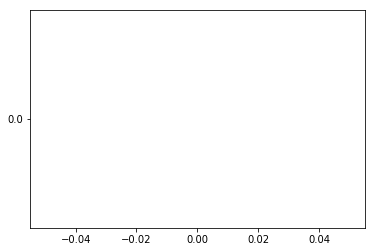

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

# Evaluating the network

Evaluation is mostly the same as training, but there are no targets. Instead we always feed the decoder's predictions back to itself. Every time it predicts a word, we add it to the output string. If it predicts the EOS token we stop there. We also store the decoder's attention outputs for each step to display later.

In [17]:
def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    

    # Create starting vectors for decoder
    decoder_input = decoder_seq = Variable(torch.LongTensor([[SOS_token]])) # SOS
    if USE_CUDA:
        decoder_input = decoder_seq = decoder_input.cuda()

    
    decoded_words = []
    K = input_variable.view(-1,1)
    Q = decoder_seq.view(1,1)
    # Run through decoder
    for di in range(max_length):
        decoder_output = model(Q,K)[0,-1,:]

        # Choose top word from output
        topv, topi = torch.topk(decoder_output, k=1, dim=-1)
        ni = topi.item()
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
        Q = torch.cat([Q, decoder_input], dim=1)
        
    return decoded_words

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [18]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    
#     print('>', pair[0])
#     print('=', pair[1])
#     print('<', output_sentence)
#     print('')
    print '>', pair[0]
    print '=', pair[1]
    print '<', output_sentence
    print ''

In [19]:
evaluate_randomly()

> SOS 亿万人民 高歌 同唱 EOS r ns d d v NOP iang NOE 5 NOR
= SOS 咱们 中国 一定 更加 富强 EOS
< 抬头挺胸 EOS 抬头挺胸 EOS 抬头挺胸 抬头挺胸 抬头挺胸 EOS EOS 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 EOS EOS 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 EOS EOS EOS 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 EOS 抬头挺胸 抬头挺胸 抬头挺胸 EOS EOS 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 抬头挺胸 EOS EOS 抬头挺胸 抬头挺胸 抬头挺胸



# Visualizing attention

A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run `plt.matshow(attentions)` to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

In [ ]:
output_words, attentions = evaluate(u"SOS 所以 我 好 愿意 EOS v r l NOP i NOE 3 NOR")
print len(output_words), attentions.shape
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes and labels:

In [ ]:
import matplotlib
zhfont = matplotlib.font_manager.FontProperties(fname="/home/k123/simhei.ttf")
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90, fontproperties=zhfont)
    ax.set_yticklabels([''] + output_words, fontproperties=zhfont)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(input_sentence)
    print 'input =', input_sentence
    print 'output =', ' '.join(output_words)
    show_attention(input_sentence, output_words, attentions)


In [ ]:
pair = random.choice(pairs)
evaluate_and_show_attention(pair[0])

In [ ]:
evaluate_and_show_attention("elle a cinq ans de moins que moi .")

In [ ]:
evaluate_and_show_attention("elle est trop petit .")

In [ ]:
evaluate_and_show_attention("je ne crains pas de mourir .")

In [ ]:
evaluate_and_show_attention("c est un jeune directeur plein de talent .")

# Exercises

* Try with a different dataset
    * Another language pair
    * Human &rarr; Machine (e.g. IOT commands)
    * Chat &rarr; Response
    * Question &rarr; Answer
* Replace the embedding pre-trained word embeddings such as word2vec or GloVe
* Try with more layers, more hidden units, and more sentences. Compare the training time and results.
* If you use a translation file where pairs have two of the same phrase (`I am test \t I am test`), you can use this as an autoencoder. Try this:
    * Train as an autoencoder
    * Save only the Encoder network
    * Train a new Decoder for translation from there